<a href="https://colab.research.google.com/github/ssooni/data_mining_practice/blob/master/dust_weather/dust_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 구글 드라이브 마운트 
제 개인 드라이브에 있는 부분이라 아래 부분은 실행해도 학습 데이터 파일은 없습니다.

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/dataset', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /dataset


In [ ]:
!ls -la /dataset/MyDrive/dust/
!pip install --upgrade tables

total 1622893
-rw------- 1 root root    2439292 Jan  5 22:44 'best_model (1).pt'
-rw------- 1 root root    2439291 Jan  5 03:42  best_model.pt
-rw------- 1 root root 1655826560 Jul  8  2019  data.hdf
-rw------- 1 root root      20499 Mar  3 16:00  LARD_ADM_SECT_SGG_11.dbf
-rw------- 1 root root        761 Mar  3 16:00  LARD_ADM_SECT_SGG_11.prj
-rw------- 1 root root     494976 Mar  3 16:00  LARD_ADM_SECT_SGG_11.shp
-rw------- 1 root root        308 Mar  3 16:00  LARD_ADM_SECT_SGG_11.shx
-rw------- 1 root root     618368 Mar  4 10:43  seoul_municipalities.shp
     |████████████████████████████████| 4.3MB 17.7MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cuda


## 데이터
데이터는 2009.01.01 ~ 2019.01.01 사이의 서울 날씨와 서울시내 구 별로 설치된 미세먼지 측정 데이터이다.  
미세먼지 측정 데이터와 기상 데이터를 각각 api를 통해서 10년치를 수집 후 hdf 파일로 저장하였으며, 그 과정은 이번 소스 코드에서 제외하였다.  
기상 데이터 항목 중에는 습도, 온도, 풍속, 퐁향, 기압을 사용하였으며, 미세먼지농도는 PM2.5 수치를 사용하였다.


*데이터 출처 : 공공데이터포털*


In [ ]:
import pandas as pd
import numpy as np

master = pd.read_hdf("/dataset/MyDrive/dust/data.hdf", "master", mode='r')

master = master.sort_index()

X_label = ['HM', 'PA', 'PS', 'PV','TA', 'TD', 'TS', 'WD', 'WS'] # 습도, 대기압, 
y_label = ['PM25']

master[X_label + y_label].head()

,HM,PA,PS,PV,TA,TD,TS,WD,WS,PM25
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,14.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,13.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,12.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,18.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,19.0


In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style('whitegrid')

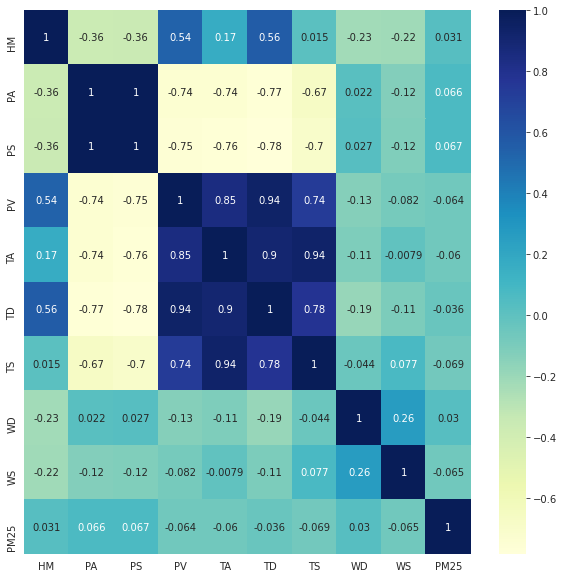

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(master[X_label + y_label].corr(), annot=True, cmap='YlGnBu')

## 데이터 전처리 및 테스트 데이터 분리
1. 누락된 데이터   
미세먼지 데이터의 누락이 있는 데이터가 있다. Nan으로 되어 있는 데이터는 학습 결과에 영향을 줄 수 있기 떄문에 반드시 처리해야 하며,  
이전 시간에 측정된 데이터를 채우는 방식을 사용했다.

2. Normalization  
기압, 습도, 온도 등은 각각 측정하는 단위가 다르고 매 시간 변화하는 크기도 다르다.  
이러한 차이 역시 학습에 영향을 줄 수 있는 부분이므로 Min-Max Sacale을 해서 0~1 사이의 값으로 변경한다. 

3. 그 외  
서울시 강남의 데이터만 사용하였다.  
Colab의 사용 가능한 RAM 제한을 넘어버리는 바람에 30000건 정도만 모델링 하는데 사용되었다.  
배치 방식으로 변경하면 램을 조금 덜 쓸 수 있다.   
학습 : 테스트 데이터의 비율은 9:1로 하였다.  
Slide Window = 20 으로 학습데이터를 재구성하였다.

In [ ]:
sample = master[master["MSRSTE_NM"]== "강남구"][X_label + y_label] # 서울시 강남구의 데이터만 사용
sample = sample.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
for l in X_label:
   sample[l] = scaler.fit_transform(sample[l].values.reshape(-1,1))

### 이상치 처리
PM2.5 미세먼지 농도의 데이터 분포를 확인 하기 위해 밀도 함수로 데이터 분포를 확인 해보았다.  
200이 넘는 적은 수의 데이터가 있는데, 상위 0.5프로를 차지하는 데이터를 이상치로 하고 제거하는 작업을 하였다. 

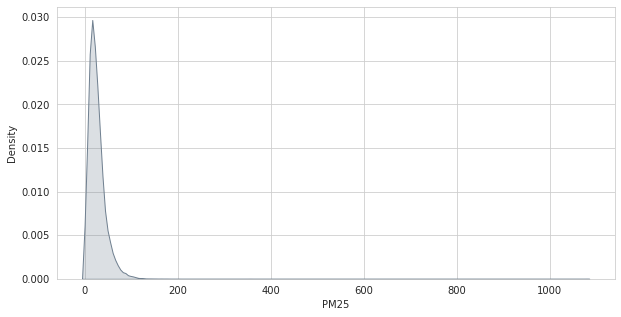

In [ ]:
plt.figure(figsize=(10,5))
sns.kdeplot(x='PM25', data=sample[['PM25']], fill=True, color='slategray');

outliner :  99.0
339 / 69280


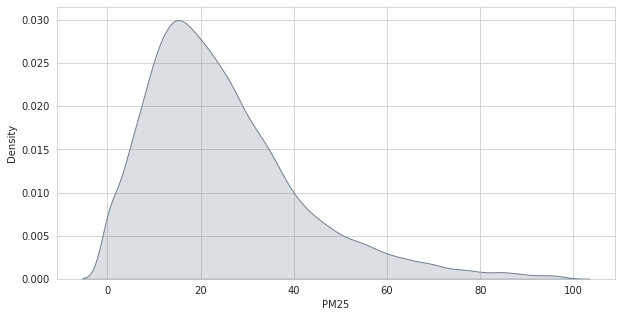

In [ ]:
outliner = sample['PM25'].quantile(0.995)
print("outliner : ",  outliner)
print(sample[sample['PM25'] > outliner].shape[0], "/", sample.shape[0])
plt.figure(figsize=(10,5))
sns.kdeplot(x='PM25', data=sample[sample['PM25'] < outliner][['PM25']], fill=True, color='slategray');

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def split_data(raw_data, lookback,batch_size=2, outliner=None, target="PM25"):
  data = []

  if outliner is not None:
    # 이상치 미만 데이터만 사용
    raw_data2 = raw_data[raw_data[target] < outliner]
    data_raw = raw_data2.to_numpy() 
  else:
    data_raw = raw_data.to_numpy()

  y = np.reshape(data_raw[:, -1], (-1, 1))

  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback): 
      data.append(data_raw[index: index + lookback])
  
  data = np.array(data);
  test_set_size = int(np.round(0.1 * data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);
  
  x_train = torch.from_numpy(data[:train_set_size, :, :-1]).type(torch.Tensor)
  y_train = torch.from_numpy(y[lookback:train_set_size+lookback, :]).type(torch.Tensor)
  
  x_test = torch.from_numpy(data[train_set_size: , :, :-1]).type(torch.Tensor)
  y_test = torch.from_numpy(y[train_set_size+lookback:, :]).type(torch.Tensor)
  
  train_set = TensorDataset(x_train, y_train)
  test_set = TensorDataset(x_train, y_train)

  dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  dataloader2 = DataLoader(test_set, batch_size=batch_size, shuffle=True)

  return x_train, y_train, x_test, y_test, dataloader, dataloader2

In [ ]:
x_train, y_train, x_test, y_test, dataloader, dataloader2 = split_data(sample, 20, 32, outliner=outliner)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([62008, 20, 9]) torch.Size([6890, 20, 9])
torch.Size([62008, 1]) torch.Size([6890, 1])


## GRU
Sequance Model의 한 종류로 LSTM의 간소화된 버전으로 알려져 있다.  


In [ ]:
class GRU(nn.Module):
  def __init__(self, n_layers, hidden_dim, input_dim, n_classes=1, dropout_p=0.2):
      super(GRU, self).__init__()
      self.n_layers = n_layers
      self.hidden_dim = hidden_dim

      self.dropout = nn.Dropout(dropout_p)
      self.gru = nn.GRU(input_dim, self.hidden_dim, num_layers=self.n_layers, batch_first=True, dropout=dropout_p)
      self.fc = nn.Linear(self.hidden_dim, n_classes)

  def forward(self, x):
      h0 = self._init_state(x.size(0))
      out, (hn) = self.gru(x, (h0.detach()))
      out = self.fc(out[:, -1, :]) 
      return out

  def _init_state(self, batch_size=1):
      weight = next(self.parameters()).data
      return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(DEVICE)

## 학습 / 테스트 결과
- 100회 반복 학습하면서 Loss의 감소를 확인.  
- Loss는 Mean Square Error를 사용해서 측정.  
- Optimiser는 Adam을 사용하였음



In [ ]:
def evaluate(model, val_iter):
  model.eval()
  corrects, total_loss = 0, 0
  
  for batch in val_iter:
    x, y = batch
    y_p = model(x.to(DEVICE))
    loss = torch.nn.MSELoss(reduction='mean')(y_p, y.to(DEVICE))
    total_loss += loss.item()

  size = len(val_iter)
  avg_loss = total_loss / size
  return avg_loss

In [ ]:
import time
import numpy

num_epochs = 100
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

model = GRU(input_dim=len(X_label), hidden_dim=32, n_classes=1, n_layers=1).to(DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.cuda.empty_cache()
best_val_loss = None
for t in range(num_epochs):
  model.train()
  for batch_idx, samples in enumerate(dataloader):
    x, y = samples

    y_train_pred = model(x.to(DEVICE))
    # print("pridiction: ", y_train_pred[:10, :], "\n Real: ", y_train[:10])
    optimizer.zero_grad()
    loss = criterion(y_train_pred, y.to(DEVICE))
    
    loss.backward()
    optimizer.step()

  avg_loss = evaluate(model, dataloader2)

  if not best_val_loss or avg_loss < best_val_loss:
      if not os.path.isdir("snapshot"):
          os.makedirs("snapshot")
      torch.save(model.state_dict(), './snapshot/best_model.pt')
 
  if t % 20 == 0:
    print("Epoch ", t, "MSE: ", avg_loss)
  hist[t] = avg_loss

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch  0 MSE:  249.5931316352112
Epoch  20 MSE:  159.0114177353488
Epoch  40 MSE:  135.6651948174948
Epoch  60 MSE:  125.10893079641556
Epoch  80 MSE:  119.70260373677509
Training time: 761.7089848518372


### Learning rate check / 학습 결과 확인
Loss가 감소하는 양상을 확인 하였다. 교과서에 나오는 정석적인 모양이라 만족!! 😊  
학습된 모델을 기반으로 예측 값과 실제 값을 비교도 해보았다. 

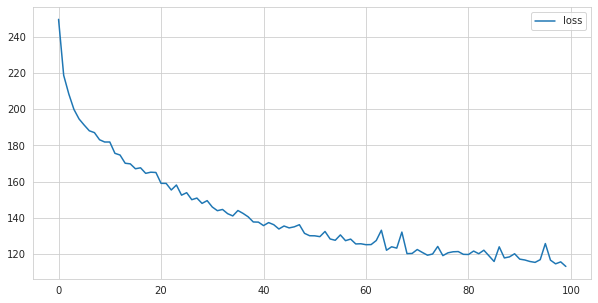

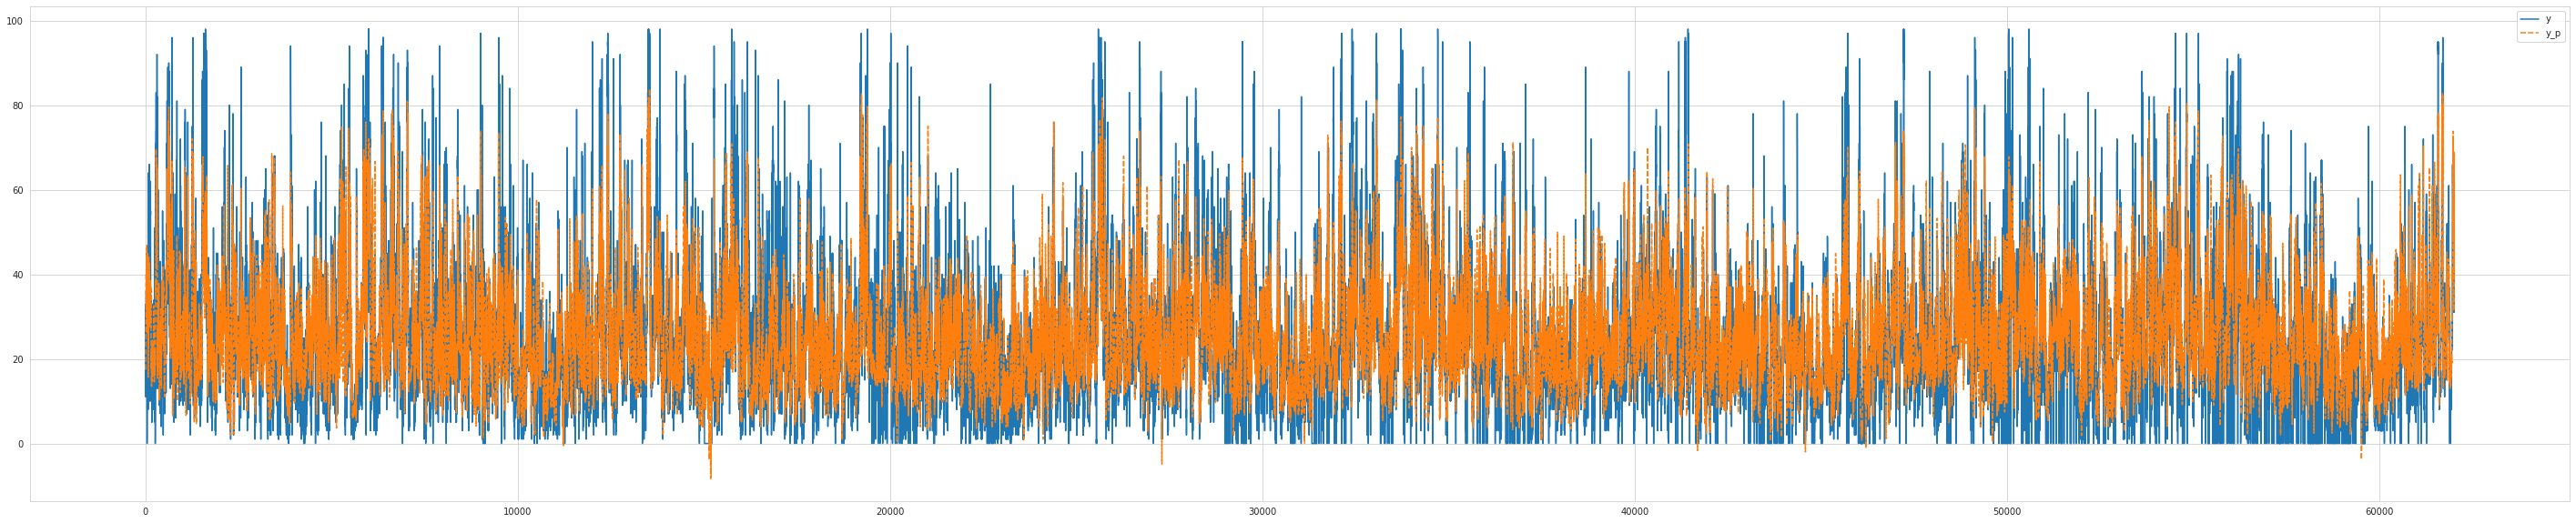

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(10,5))
sns.lineplot(data=pd.DataFrame(hist, columns=["loss"]))

model.eval()
prediction = model(x_train.to(DEVICE)) 
a = pd.DataFrame(y_train.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())
plt.figure(figsize=(50,10))
sns.lineplot(data=a)

### 학습결과 
어느 정도 추세는 맞추는 듯 하는데, 실제와 차이가 많이 나는 구간이 있다.  
MSELoss도 학습데이터에 비하면 너무 큰 편인데, 학습데이터에 과적합이 의심스럽다.  



과적합 회피  
1. hidden layer 조정 : 256 -> 128 로 조정 (모델 복잡도를 낮추어 보았다.)  
256 : 365.24937  
128 : 307.15707  
64 : 305.79993  
32 : 275.61227


그 외
1. 미세먼지 데이터를 봤을 때 한 번씩 주변 시간 데이터에 비해 값이 크게 변화하는 경우가 있는데,  
해당 도메인의 지식이 없어서 해당 부분에 대한 전처리가 되지 않은 것이 영향을 준 거 같다.
2. 전체 데이터를 사용할 수 있게 최적화를 시도해서 학습을 한다.   
3. 새로운 Feature를 추가해 보는 것도 고민해보자.  
예) 강남구 주변의 미세먼지 데이터를 Feature로 사용. 

(6890,)
[275.61227]


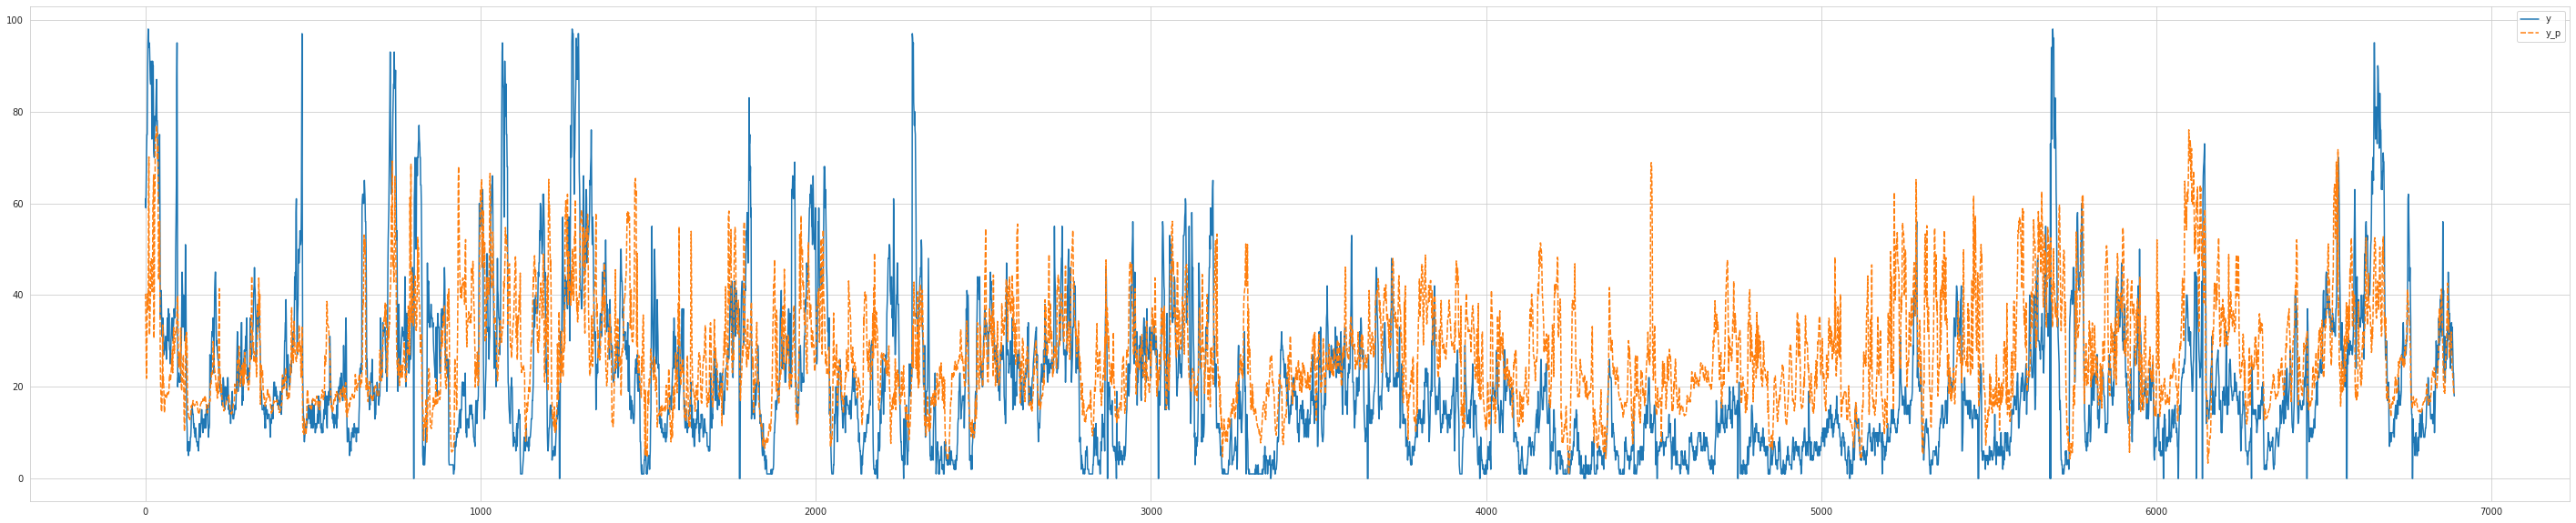

In [ ]:
# model.load_state_dict(torch.load('./snapshot/best_model.pt'))
model.eval()
prediction = model(x_test.to(DEVICE)) 
print(prediction.view(-1).cpu().detach().numpy().shape)
a = pd.DataFrame(y_test.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())

loss = sum((a[["y_p"]].values - a[["y"]].values)**2) / a.shape[0]
print(loss)
plt.figure(figsize=(50,10))
sns.lineplot(data=a)

https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f


In [ ]:
## 지도를 추출
!pip install pyshp
!pip install geopandas

     |████████████████████████████████| 225kB 22.0MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=592365938bc1d4d3488ad990ca3318eb30b49ef8050b00208de2ccbb434762a1
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp
     |████████████████████████████████| 1.0MB 18.7MB/s 
     |████████████████████████████████| 6.5MB 52.6MB/s 
     |████████████████████████████████| 14.8MB 214kB/s 


In [ ]:
!ls -la /dataset/MyDrive/dust/

total 1622893
-rw------- 1 root root    2439292 Jan  5 22:44 'best_model (1).pt'
-rw------- 1 root root    2439291 Jan  5 03:42  best_model.pt
-rw------- 1 root root 1655826560 Jul  8  2019  data.hdf
-rw------- 1 root root      20499 Mar  3 16:00  LARD_ADM_SECT_SGG_11.dbf
-rw------- 1 root root        761 Mar  3 16:00  LARD_ADM_SECT_SGG_11.prj
-rw------- 1 root root     494976 Mar  3 16:00  LARD_ADM_SECT_SGG_11.shp
-rw------- 1 root root        308 Mar  3 16:00  LARD_ADM_SECT_SGG_11.shx
-rw------- 1 root root     618368 Mar  4 10:43  seoul_municipalities.shp


In [ ]:
import geopandas as geopd
shp_path = "/dataset/MyDrive/dust/LARD_ADM_SECT_SGG_11.shp"
sf = geopd.read_file(shp_path,encoding='MS949')
sf["SGG_NM"] = sf["SGG_NM"].str.replace("서울시", "")

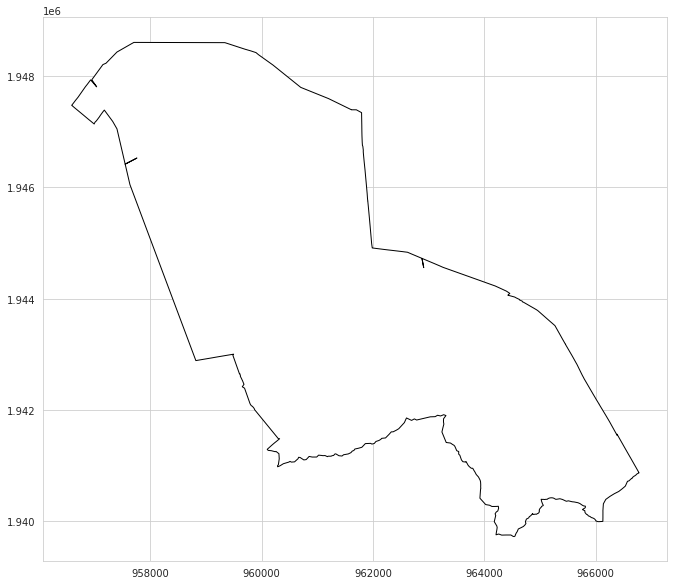

In [ ]:
import imageio
from IPython.display import Image

fig, ax = plt.subplots(figsize=(16,10))
gangnam = sf[sf["SGG_NM"] == "강남구"]
gangnam.plot(ax=ax, color='w', edgecolor='black') 

In [ ]:
a = gangnam.merge(master[["MSRSTE_NM", "PM25"]], left_on=["SGG_NM"], right_on=["MSRSTE_NM"])
a

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,GID,geometry,MSRSTE_NM,PM25
0,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,14.0
1,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,17.0
2,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,13.0
3,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,14.0
4,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,17.0
...,...,...,...,...,...,...,...,...
69275,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,27.0
69276,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,23.0
69277,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,23.0
69278,11680,강남구,33,11680,129,"POLYGON ((958696.114 1948605.678, 959195.920 1...",강남구,19.0


In [ ]:
## SAVE MODEL / LEARNING RATE INFORMATION
from google.colab import files
files.download('./curve_2_model_3_batch.gif') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>